# Preprocessing

In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import tifffile
import fastplotlib as fpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

from skophys.preprocessing import Vectorizer, UnVectorizer, PercentileFilter

import lbm_caiman_python as lcp

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Available devices:
✅ (default) | NVIDIA RTX A4000 | DiscreteGPU | Vulkan | 560.94
✅ | NVIDIA RTX A4000 | DiscreteGPU | D3D12 | 
❗ | Microsoft Basic Render Driver | CPU | D3D12 | 
✅ | NVIDIA RTX A4000 | DiscreteGPU | D3D12 | 
❗ | NVIDIA RTX A4000/PCIe/SSE2 | Unknown | OpenGL | 


c:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (12, 8),
    'ytick.major.left': True,
})
jet = mpl.colormaps['jet']
jet.set_bad(color='k')

## scanreader

In [3]:
raw_data_path = Path().home() / 'lbm_data' / 'behavior'
raw_data_path.is_dir()

True

In [12]:
scan = lcp.read_scan([str(x) for x in raw_data_path.glob('*')], join_contiguous=True)

In [13]:
scan.num_fields

2

In [5]:
save_path = raw_data_path.parent / 'assembled'

## Save as `.tiff` / `.zarr`

In [ ]:
lcp.save_as(scan, save_path,overwrite=True, planes=[0, 1, 13, 24, 28], frames=np.arange(0, 1000))

Planes: [0, 1, 13, 24, 28]


In [6]:
movie = tifffile.imread(save_path / 'roi_0_plane_24.tiff')
movie.shape

(1000, 212, 212)

## Threshold your movie

In [7]:
t = 2000
mask = movie < t
binary_mask = mask > 0

selection = movie.copy()
selection[~binary_mask] = 0
selection.shape

(1000, 212, 212)

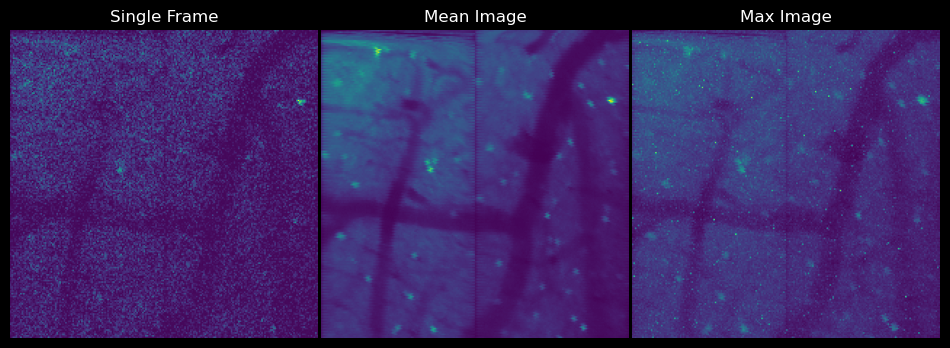

In [47]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=3,)

ax[0].imshow(movie[1, ...])
ax[0].title.set_text("Single Frame")
ax[0].axis('off')

ax[1].imshow(np.mean(movie, axis=0))
ax[1].title.set_text("Mean Image")
ax[1].axis('off')

ax[2].imshow(np.max(movie, axis=0))
ax[2].title.set_text("Max Image")
ax[2].axis('off')

plt.show()

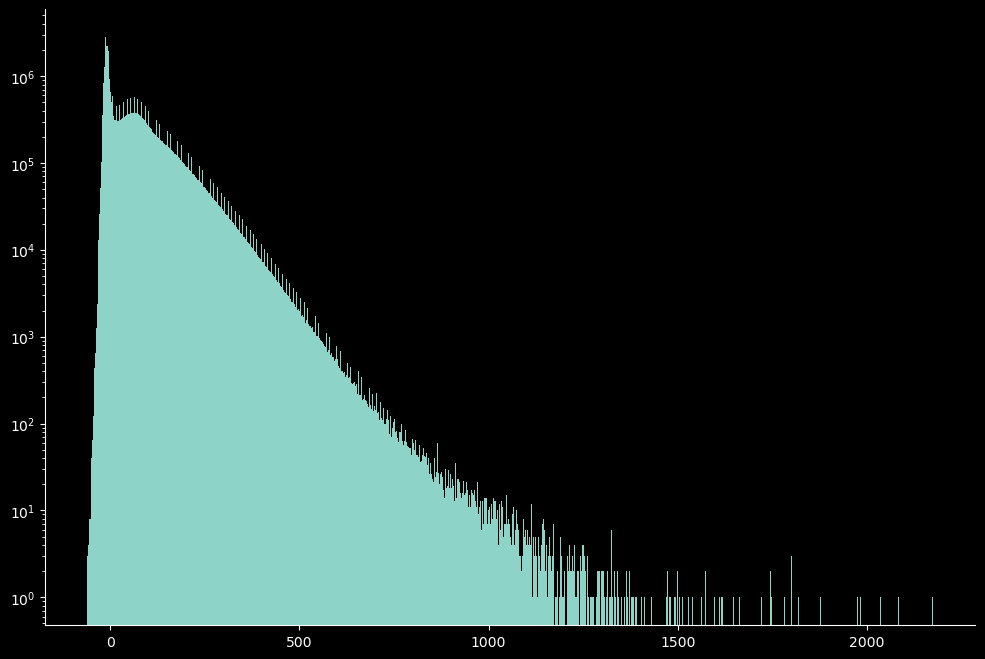

In [9]:
unvec = UnVectorizer(movie.shape[1:])
plt.hist(movie.ravel(), bins=1_000)
plt.semilogy()
plt.show()

In [10]:
iw = fpl.ImageWidget(data=movie)
iw.show()

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

No such comm: 122a8927db5e4e13ba75974e1e7834bf
No such comm: 122a8927db5e4e13ba75974e1e7834bf


In [15]:
iw.close()

## Correlation / Max Images

In [ ]:
from caiman.summary_images import local_correlations, max_correlation_image

In [18]:
corr_image = local_correlations(movie, swap_dim=False)
max_corr = max_correlation_image(movie, swap_dim=False)

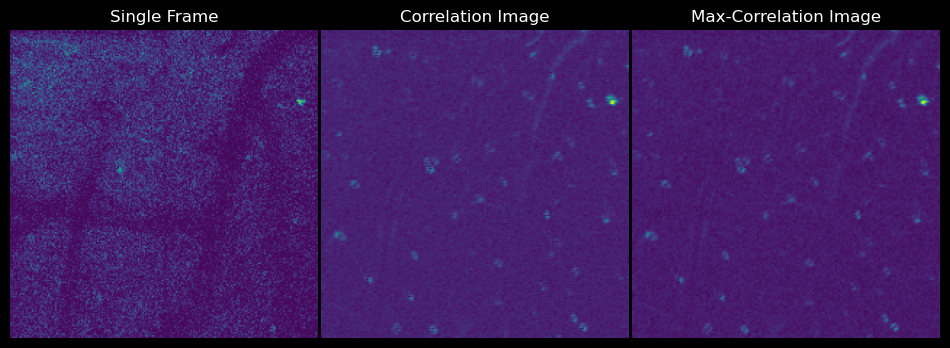

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3,)

ax[0].imshow(movie[1, ...])
ax[0].title.set_text("Single Frame")
ax[0].axis('off')
ax[1].imshow(corr_image)
ax[1].title.set_text("Correlation Image")
ax[1].axis('off')
ax[2].imshow(max_corr)
ax[2].title.set_text("Max-Correlation Image")
ax[2].axis('off')

plt.show()

In [24]:
corrected = lcp.fix_scan_phase(movie, -1)

# Scan-phase correction

In [46]:
corrected.shape

(1000, 212, 212)

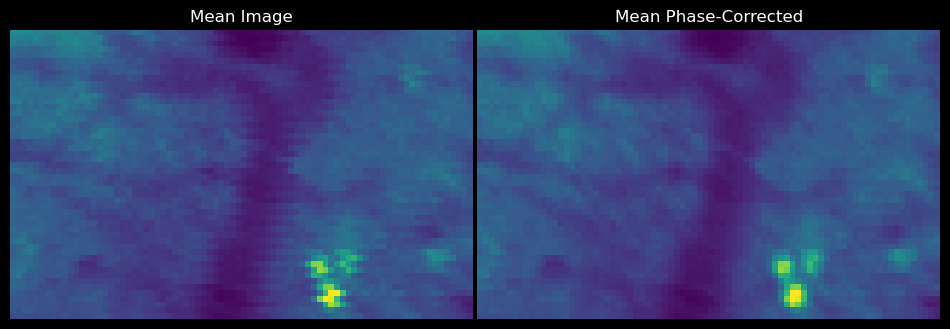

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2,)

ax[0].imshow(np.mean(movie[:, 50:100, 20:100], axis=0))
ax[0].title.set_text("Mean Image")
ax[0].axis('off')
ax[1].imshow(np.mean(corrected[:, 50:100, 20:100], axis=0))
ax[1].title.set_text("Mean Phase-Corrected")
ax[1].axis('off')

plt.show()

In [ ]:
save_path = Path().home() / 'lbm_data' / 'batch' / 'test_roi.tiff'
tifffile.imwrite(save_path, corrected)

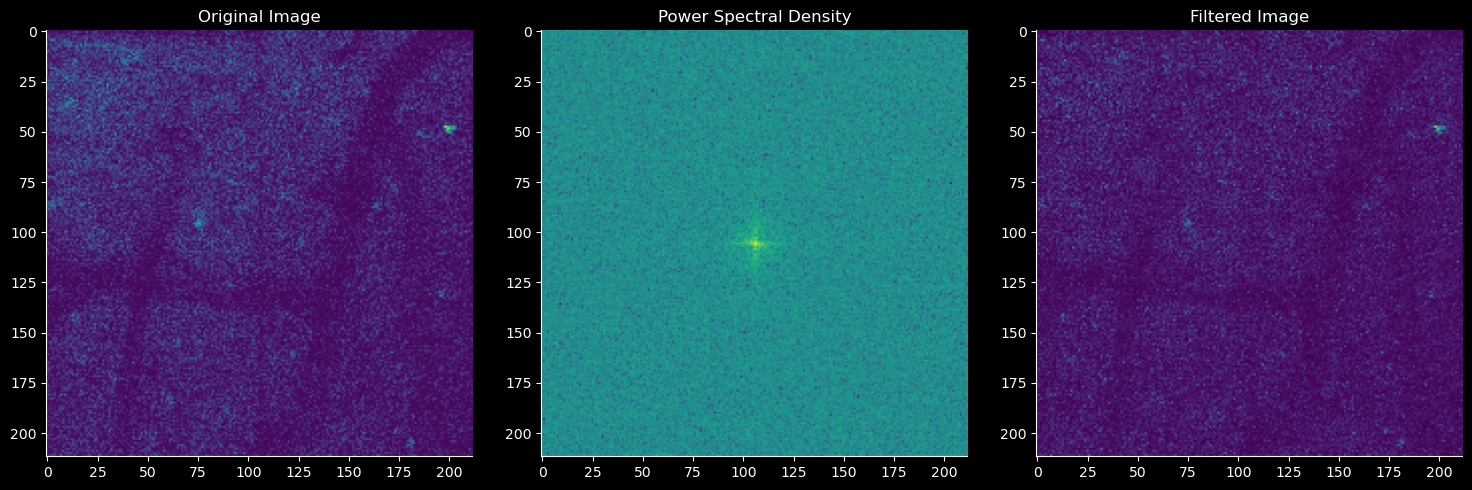

In [23]:
f_transform = np.fft.fft2(movie)
f_shift = np.fft.fftshift(f_transform)  # Shift zero frequency to the center

psd = np.abs(f_shift)**2

# Remove 1st/99th percentile
low_percentile = np.percentile(psd, 1)
high_percentile = np.percentile(psd, 99)

filter_mask = (psd > low_percentile) & (psd < high_percentile)
filtered_shift = f_shift * filter_mask

# reconstruct the image
filtered_transform = np.fft.ifftshift(filtered_shift)
filtered_image = np.fft.ifft2(filtered_transform)
filtered_image = np.abs(filtered_image)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(selection[1, ...], cmap='viridis')
axs[0].set_title("Original Image")
axs[1].imshow(np.log10(psd + 1)[1, ...], cmap='viridis')
axs[1].set_title("Power Spectral Density")
axs[2].imshow(filtered_image[1, ...], cmap='viridis')
axs[2].set_title("Filtered Image")

plt.tight_layout()
plt.show()

## Percentile Filtering

In [31]:
from ipywidgets import HBox

iw_movie = fpl.ImageWidget(movie, cmap="viridis")
tfig = fpl.Figure()

raw_trace = tfig[0, 0].add_line(np.zeros(movie.shape[0]))

@iw_movie.managed_graphics[0].add_event_handler("click")
def pixel_clicked(ev):
    col, row = ev.pick_info["index"]
    raw_trace.data[:, 1] =  iw_movie.data[0][:, row, col]
    tfig[0, 0].auto_scale(maintain_aspect=False)

HBox([iw_movie.show(), tfig.show()])

RFBOutputContext()

RFBOutputContext()

In [33]:
iw_movie.window_funcs = {"t": (np.mean, 1)}

In [32]:
filt_movie = PercentileFilter(window_size=5, quantile=5).transform(movie)

In [34]:
iw_movie.set_data(unvec.transform(filt_movie), reset_indices=False)

In [36]:
ss = RobustScaler()

In [37]:
Y = ss.fit_transform(filt_movie.T).T

In [38]:
iw_movie.set_data(unvec.transform(Y), reset_indices=False)

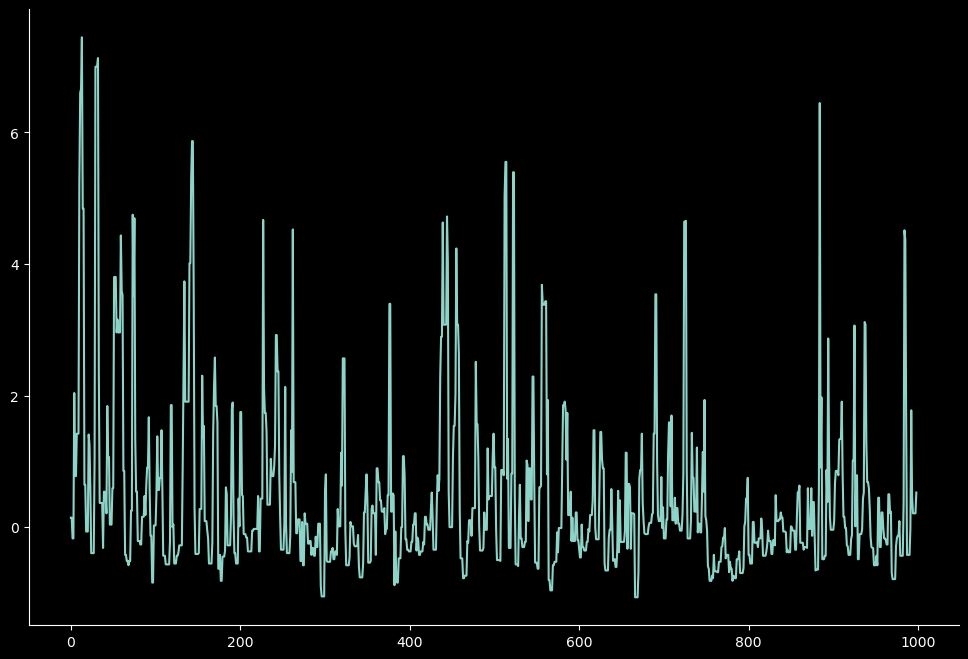

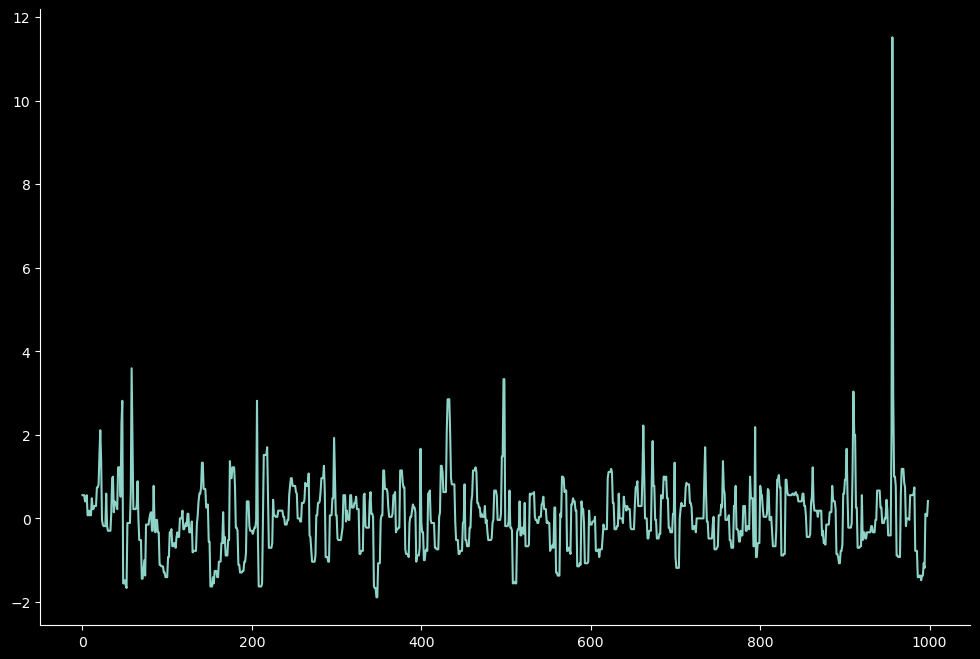

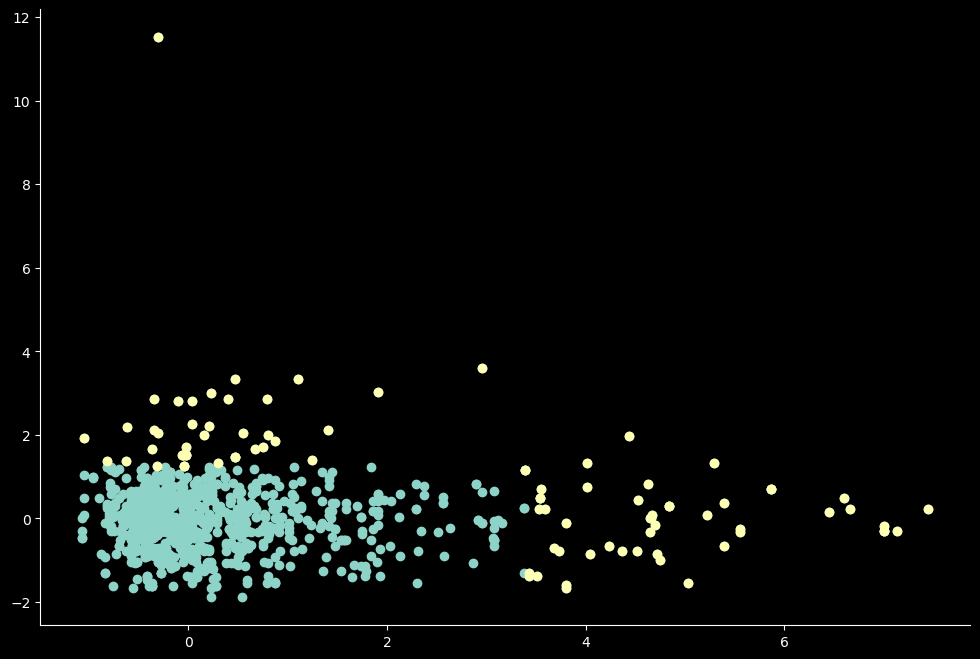

In [39]:
Y = Y[:, :-1]

i1 = 2502
i2 = 2510

u = Y[i1]
v = Y[i2]

high_vals = (u > np.percentile(u, 95)) | (v > np.percentile(v, 95))

plt.plot(u)
plt.show()
plt.plot(v)
plt.show()

plt.scatter(u, v)
plt.scatter(u[high_vals], v[high_vals])
plt.show()

In [ ]:
h = np.array([1, 0])
s = np.column_stack([u, v])
projections = (s @ h)[:, None] * h

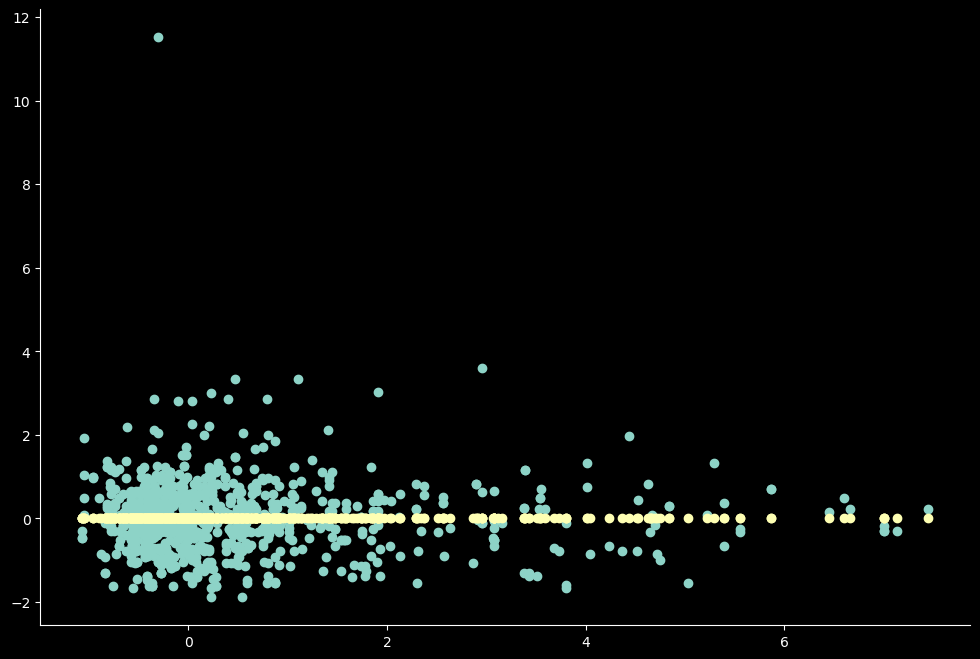

In [41]:
plt.scatter(Y[i1, :], Y[i2, :])
plt.scatter(projections[:, 0], projections[:, 1])
plt.show()

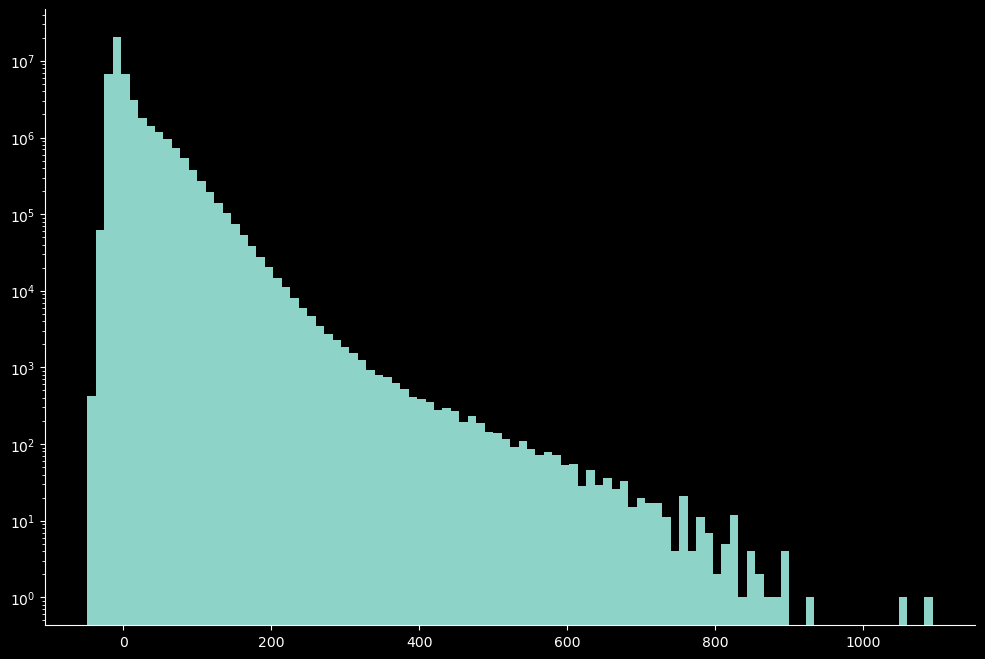

In [43]:
plt.hist(filt_movie.ravel(), bins=100)
plt.semilogy()
plt.show()